In [724]:
# Basics
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Perceptron 

## A Brief Walkthrough 
1. Read the dataset and store it.

2. Perform some exploratory data analysis and preprocessing which includs swapping 0's with -1's, duplicate row removal, outlier removal.

3. Implement the perceptron algorithm, and it's auxiliary functions like loss, prediction.

4. Implement K-fold cross validation and report mean error.

5. Use K-fold cross validation to select the best hyperparameter based on min average loss.

6. Run the model with best hyperparameter selected in step 5.
    

In [840]:
data=pd.read_csv("BankNote_Authentication.csv")

#Adding a column of "1's" to include bias term as one of the trainable parameters(weights)
data.insert(4,"bias",[1]*data.shape[0],True) 

#Changing the output labels from {0,1} to {-1,1}, which will allow us to have a condensed checking condition
data['class']=data['class'].replace(to_replace =0, 
                 value =-1)
data.head()

,variance,skewness,curtosis,entropy,bias,class
0,3.62160,8.6661,-2.8073,-0.44699,1,-1
1,4.54590,8.1674,-2.4586,-1.46210,1,-1
2,3.86600,-2.6383,1.9242,0.10645,1,-1
3,3.45660,9.5228,-4.0112,-3.59440,1,-1
4,0.32924,-4.4552,4.5718,-0.98880,1,-1


In [841]:

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   bias      1372 non-null   int64  
 5   class     1372 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 64.4 KB


In [842]:
#Removing duplicate rows from the dataset
data.drop_duplicates(subset=None,keep='first',inplace=True, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1348 non-null   float64
 1   skewness  1348 non-null   float64
 2   curtosis  1348 non-null   float64
 3   entropy   1348 non-null   float64
 4   bias      1348 non-null   int64  
 5   class     1348 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 63.3 KB


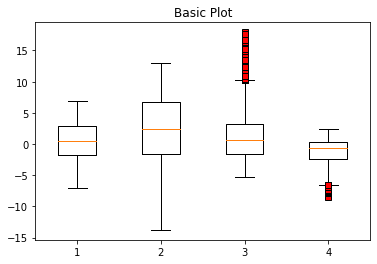

In [843]:
#Detecting outliers using Box Plot method
fig1, ax1 = plt.subplots()
red_square = dict(markerfacecolor='r', marker='s')
ax1.set_title('Basic Plot')
ax1.boxplot([data['variance'],data['skewness'],data['curtosis'],data['entropy']],flierprops=red_square)
plt.show()

## Outlier Detection and Treatment

The former section deals with detection whereas the following section is concerned about treatment.

__Detection__
* As there're very limited number of features, we decided to plot the features out to visualise which feature has outliers.
* Curtosis and Entropy is supposedly having some outliers and we need to decide a way to treat them.

__Treatment__
* Due to the dataset being small, initially the idea was to cap the values which're above the upper whisker with the tip of upper whisker and data below the lower whisker with the lower whisker value.

* But it has been observed that removing outliers performs exceptionally well than retaining them, so the treatment is finalized to removing the outliers.

In [844]:
#Outlier Treatment
# Removing outliers based on whether the points lie above or below whiskers
outlier_columns=['curtosis','entropy']

for i in outlier_columns:
    data[i]=sorted(data[i])
    q1=np.percentile(data[i],25)
    q3=np.percentile(data[i],75)
    IQR=q3-q1
    lower=q1-(1.5*IQR) #Lower whisker
    upper=q3+(1.5*IQR) #Upper whisker

    data= data.drop(data[data[i] <lower ].index)
    data=data.drop(data[data[i]>upper].index)


   

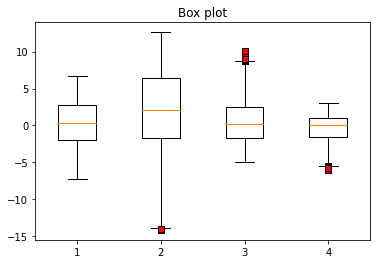

In [908]:
#Box plot after removing outliers
fig1, ax1 = plt.subplots()
red_square = dict(markerfacecolor='r', marker='s')
ax1.set_title('Box plot')
ax1.boxplot([data['variance'],data['skewness'],data['curtosis'],data['entropy']],flierprops=red_square)
plt.show()

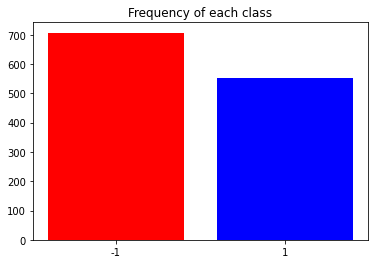

In [846]:
#To check the balance/imbalance of classes
plt.bar(x=['-1','1'], height=[(data['class'] == -1).sum(),(data['class'] == 1).sum()], color=['red','blue'])
plt.title('Frequency of each class');



In [847]:
# Standardizing the features so that the scale becomes smaller but the information retains
cols_to_norm = [ 'variance', 'skewness', 'curtosis','entropy']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.mean() / x.std()))
data.head()

,variance,skewness,curtosis,entropy,bias,class
31,1.32138,3.283149,-4.935603,-6.028459,1,-1
32,4.12988,7.272749,-4.898803,-5.971559,1,-1
33,-1.13213,9.066849,-4.877303,-5.842259,1,-1
34,-1.78322,0.464829,-4.869603,-5.837159,1,-1
35,2.27208,6.097449,-4.861103,-5.820359,1,-1


In [848]:
#Shuffling data to create randomness
data = data.sample(frac=1).reset_index(drop=True)
train_split_percent = 0.8
size = data.shape[0]
train=data.iloc[:int(train_split_percent * size),:]
test=data.iloc[int(train_split_percent * size):,:]



In [849]:
y_train, x_train=train['class'].to_numpy(), train.drop(['class'],axis=1).to_numpy()
y_test, x_test=test['class'].to_numpy(), test.drop(['class'],axis=1).to_numpy()



## Before moving on to the perceptron() algorithm :-

* __Convergence Criteria__ :-  We find the mean weight vector $ W_{mean}=\frac{1}{lookback}\Sigma_{i=curr-lookback}^{curr} W_i$, where __curr=current iteration number__  and check whether the 
  difference(or manhattan distance) b/w all those weight vectors $ W_i $ and $ W_{mean} $ is less than a certain tolerance value $ \sigma $, if the condition satisfies, that indicates weights are not deviating much from the mean and we can put our algorithm to a halt. To express it formally the condition is:
  
  $ |W_i - W_{mean} | \leq \sigma, \forall i \in [curr-Lookback, curr] $
 
* __Lookback__:- A trainable hyperparameter, this variable stores how far we're looking into the past iteration weight values for checking the convergence criterion.
 
 


In [850]:
def perceptron1(x_train,y_train,lookback):
    w_t=np.ones(5) #Intialized weights vectors with all 1's(will keep on updating as the algo progresses)
    
    count=0
    w_t_prev=w_t
    
    sample=[w_t]
    
    for t in range(1000):
        
        row_num=np.random.randint(0,x_train.shape[0]-1)
        
       
        #Checking for dissonance b/w prediction and output label, we only update weights based on requirement basis.
        if np.dot(w_t,x_train[row_num,:])*y_train[row_num] <0: 
            
            count=0
            #If the actual output label was +ve and predicted was -ve, the updation ensures weight vectors shift towards +ve side
            w_t=w_t + y_train[row_num]*x_train[row_num,:] 
            
            
        # If all weight parameters of successive iterations are within some tolerance 
        #away from 0, we can conclude them to be equal   
        
         #If "lookback" consequtive updates don't witness much of a change, we declare convergence and break free
       
        if(t>lookback):
            start=t-lookback
            wt_mean=np.mean(sample[start:start+lookback],axis=0)
            cnt=0
            for i in range(start,start+lookback):
                if (all(abs(w_t[i]-wt_mean[i])<0.5 for i in range(len(w_t)))):
                    cnt+=1
                    
            if(cnt==lookback):
                
                break
                    
        w_t_prev=w_t
        sample.append(w_t)
            
            
    return w_t,t

In [851]:
#Incarnation of perceptron loss function
def loss_fn(y_test,pred):
    loss=0
    for i in range(len(pred)):
        loss+=max(0,-y_test[i]*pred[i])
        
    return (loss/len(y_test))*100


In [852]:
#Function responsible for making prediction based on trained weights
def prediction(x,w_t):
    pred= np.matmul(x,w_t)
    
    #If the prediction is +ve, we output +1 else -1
    pred= [1 if pred[i]>=0 else -1 for i in range(pred.shape[0]) ] 
    
    return pred
    

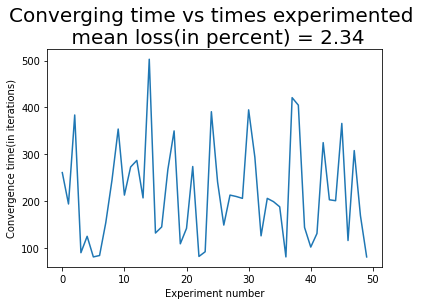

In [857]:
loss=[]
iterations=[]
for i in range(50):
    w_t,itr=perceptron1(x_train,y_train,80)
    loss.append(loss_fn(y_test,prediction(x_test,w_t)))
    iterations.append(itr)
 

plt.plot(iterations)
plt.ylabel("Convergence time(in iterations)")
plt.xlabel("Experiment number")
plt.title('Converging time vs times experimented \n mean loss(in percent) = %s'%(np.round(np.mean(loss),2)),fontsize=20)
plt.show()

## Key insights and interpretations:-

* The graph above demonstrates that the algorithm seldom hit it's max iteration count(1000) and breaks much before that,
  hinting towards early convergence in most of the cases with a pretty convincing mean error rate.
  
* As the mean error rate sits in a sweet spot, we can also infer that the data is almost linearly seperable.

In [858]:
#K-fold cross validation on the training set, often used to select learnable hyperparameters based on it's average
#performance on k validation sets across k iterations

def k_fold_cross_val(k,data,lookback):
    
    #Randomizing data to introduce randomness while picking validation set
    data = data.sample(frac=1).reset_index(drop=True)
    
    size=int(data.shape[0]/k)
    W=[]
    Loss=[]
    data=data.to_numpy() #Converting dataframe to numpy as, moving forward we'll seek help of the rich numpy library
    
    #Across all the iterations we make sure each of the "k" parts get to become a validation set once, while rest of
    # k-1 parts will act as our training set
    for i in range(k):
        
        #This is the part where training and validation set part ways to serve their purpose, 
        #and are further splitted into features, outputs.
        train=data[:i*size,:]
        vald=data[i*size:(i+1)*size,:]
        
        if((i+1)*size !=data.shape[0]):
            if(i==0):
                train=data[(i+1)*size:,:]
                
            else:
                train=np.vstack((train,data[(i+1)*size:,:])) #stacking vertically
                
        
        
        y_train, x_train=train[:,-1], train[:,:-1]
        y_vald, x_vald=vald[:,-1], vald[:,:-1]
        
        
        
        #Model is trained, predictions are made and the loss is collected to be used later for averaging
        w_t,itr=perceptron1(x_train,y_train,lookback)
       
        pred= prediction(x_vald,w_t)
        
        W.append(w_t)
       
        Loss.append(loss_fn(y_vald,pred))
        
    
    
    
    #Returning mean loss
    return np.mean(Loss)
        
        

In [859]:
print("Cross validated mean error is %s"%(np.round(k_fold_cross_val(14,train,80),2)))

Cross validated mean error is 2.31


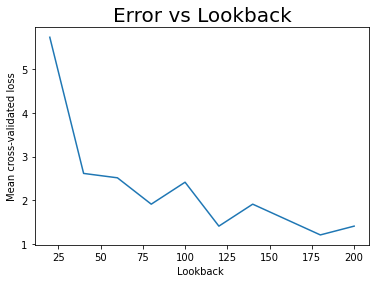

In [862]:
lookback_list=[20, 40, 60, 80, 100, 120, 140, 180, 200]
loss=[]
for lookback in lookback_list:
    loss.append(k_fold_cross_val(14,train,lookback))


plt.plot(lookback_list,loss)
plt.xlabel("Lookback ")
plt.ylabel("Mean cross-validated loss")
plt.title("Error vs Lookback",fontsize=20)
plt.show()

## Observations

* Although we can't offer a guaranteed point estimate of the lookback value owing to the volatile nature of the above plot, we can certainly produce a range containing the optimal value with decent degree of confidence.__

* [75,150] is an empirical range where the best value of lookback mostly lies, and we'll be picking 125 as our best model hyperparameter in the following segment.

 



In [722]:
def F1(pred,y_test):
    
   
    
    for i in range(len(pred)):
         #if prediction and actual result is equal and positive, we've found a True Positive
        TP=[1 if (pred[i]==1 and y_test[i]==1) else 0 for i in range(len(pred))] 
    
    
        #if prediction result is +ve but actual result is -ve it's a False Positive
        FP=[1 if (pred[i]==1 and y_test[i]==-1) else 0 for i in range(len(pred))]
    
    
        #if prediction result is -ve but actual result is +ve it's a False Negative
        FN=[1 if (pred[i]==-1 and y_test[i]==1) else 0 for i in range(len(pred))]
    
    
        #Harmonic mean of precision and recall
    F1= sum(TP)/(sum(TP)+ 0.5*(sum(FP)+sum(FN)))
    
    return F1

In [751]:
w_t,itr=perceptron1(x_train,y_train,125)

print("F1 score= %s"%(np.round(F1(prediction(x_test,w_t),y_test),2)))


F1 score= 0.99


# MCMC approximation 

## A Brief Walkthrough
1. Plot distribution of prior, likelihood and posterior
2. Use mcmc sampling to find approximate posterior distribution.
3. Test convergence(in terms of iterations) different values of proposal width and draw insights.

In [2]:
np.random.seed(1)

In [3]:
def normal_pdf(x,mu,sigma):
    
    y=np.exp(-np.square(x-mu)/(2*sigma*sigma))/(np.sqrt(2*np.pi*sigma*sigma))
    return y
    

###  Prior ~ $ N(\mu_P, \sigma_P^2) $ ~ N(25, 25) 

Std of prior=5
 Mean of prior=25


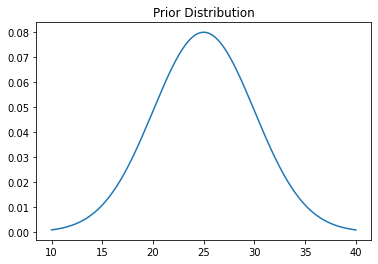

In [917]:
#Plotting prior
mu_prior=25; std_prior=5; var_prior=np.square(std_prior)

print("Std of prior=%s\n Mean of prior=%s"%(round(std_prior),round(mu_prior)))
prior_x=np.linspace(mu_prior - 3*std_prior, mu_prior + 3*std_prior,10000)
plt.plot(prior_x, normal_pdf(prior_x,mu_prior,std_prior))
plt.title('Prior Distribution')
plt.show()

## Deriving pdf of Likelihood

<ul>
    <li> There are n=50 independent trials</li>
    <li> Each data point is sampled from a $ N(\mu=10, \sigma^2=25) $ </li>
</ul>

P(X_1=x_1,...X_n=x_n | $ \mu,\sigma^2 $)= L($ \mu, \sigma^2 $)= $ \prod_{i=1}^{n}\frac{1}{\sqrt{2*\pi*\sigma^2}}*exp(\frac{-1}{2\sigma^2}(x_i - \mu)^2) $

or, $ (\frac{1}{\sqrt{2*\pi*\sigma^2}})^n exp(\frac{-1}{2\sigma^2}\Sigma^n_{i=1}(x_i - \mu)^2) $

$ \propto exp({\frac{-1}{2\sigma^2}\Sigma^n_{i=1}(x_i^2 + \mu^2 -2\mu x_i )}) $

$ or, exp({\frac{-1}{2\sigma^2}(\Sigma^n_{i=1}x_i^2 + n\mu^2 -2\mu n \bar{x} )}) $

$ or, exp({\frac{-n}{2\sigma^2}(\mu^2 -2\mu\bar{x} + \frac{1}{n}\Sigma_{i=1}x_i^2)}) $

$ or, exp({\frac{-n}{2\sigma^2}(\mu^2 -2\mu\bar{x} + \bar{x}^2 - \bar{x}^2 + \frac{1}{n}\Sigma_{i=1}x_i^2)}) $

$ or, exp( \frac{-n}{2\sigma^2}((\mu - \bar{x})^2 - \sigma^2)) $

$ or, exp( \frac{-n}{2\sigma^2}(\mu - \bar{x})^2 + \frac{n}{2})) $

$ \propto exp(\frac{-n}{2\sigma^2}(\mu - \bar{x})^2) $

Product of Normal distributions is a Normal distribution,comparing the above expression with $N(\mu_{L},\sigma_{L}^{2}) \propto exp({\frac{-1}{2\sigma_L^2}(\mu-\mu_L)^2})=exp({\frac{-1}{2\sigma_L^2}(\mu^2 - 2\mu\mu_L + \mu_L^2 )})$, we get:-

### $ \mu_L=\frac{1}{n}\Sigma_{i=1}{n}x_i=\bar{x}, \sigma_L^2= \frac{\sigma^2}{n} $

### Likelihood ~ $ N(\mu_{L}=\bar{x}, \sigma_{L}^{2}=\frac{\sigma^2}{n} )$

Std deviation of likelihood=10.27 
 Mean of likelihood=0.71


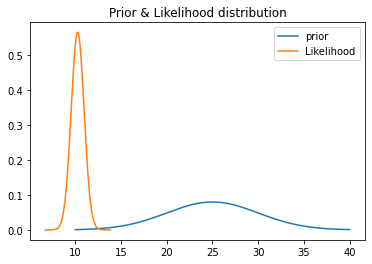

In [916]:
# Sampling 50 random points from the normal distribution
sample=np.random.normal(10,5,50)

#Setting parameters for likelihood distribution, 

mu_lik=np.mean(sample)

std_lik=std_prior/np.sqrt(50)
print("Std deviation of likelihood=%s \n Mean of likelihood=%s"%(round(mu_lik,2),round(std_lik,2)))
var_lik= np.square(std_lik)

x_lik=np.linspace(mu_lik- 5*std_lik, mu_lik + 5*std_lik, 10000)


plt.plot(prior_x, normal_pdf(prior_x,mu_prior,std_prior), label='prior')
plt.plot(x_lik, normal_pdf(x_lik, mu_lik, std_lik), label='Likelihood')
plt.title('Prior & Likelihood distribution')
plt.legend()
plt.show()

## Deriving pdf of Posterior
 $ Prior~N(\mu_p, \sigma^2_p), Likelihood ~ N(\bar{x}, \frac{\sigma^2}{n}) $
 
 $ Posterior \propto Prior \times Likelihood ~ N(\mu_{post},\sigma_{post}^2) $
 
 $ g(\mu, y_1,y_2...y_n) \propto Prior(\mu) \times Likelihood(y_1,y_2,...y_n | \mu) $
 
 $ \propto exp(\frac{-1}{2\sigma^2_p}(\mu - \mu_p)^2) \exp(\frac{-n}{2\sigma^2}(\mu - \bar{x})^2)$
 
 $ = exp(\frac{-1}{2\sigma^2_p}(\mu^2 - 2\mu \mu_p +\mu_p^2)) \exp(\frac{-n}{2\sigma^2}(\mu^2 - 2\mu\bar{x} +\bar{x}^2))$
 
 $ = exp(\frac{-1}{2}[\mu^2(\frac{1}{\sigma_p^2} +\frac{n}{\sigma^2}) - 2\mu(\frac{\mu_p}{\sigma_p^2} + \frac{n\bar{x}}{\sigma^2}) + \frac{\mu_p^2}{\sigma_p^2} + \frac{\bar{x}^2}{\sigma^2}]) $
 
Compare the above expression with:- $ exp(\frac{-1}{2\sigma_{post}}[\mu^2 + \mu_{post}^2 -2\mu\mu_{post}])  $




 $ N(\mu_{post}= \frac{\mu_p\sigma^2 + n\bar{x}\sigma_p^2}{\sigma^2 + \sigma_p^2 n} , \sigma_{post}^2=\frac{\sigma^2 \sigma_p^2}{\sigma^2 + \sigma_p^2 n}) $

Std deviation of posterior=0.7 
 Mean of posterior=10.28


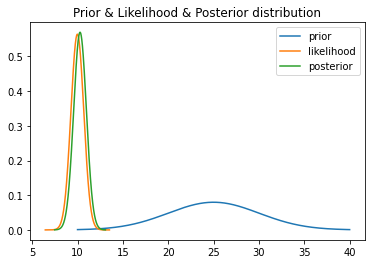

In [915]:
#Returns variance and mean of posterior given necessary inputs of prior and likelihood
def posterior(mu_prior,mu_lik, std_prior, std_likelihood,n):
    
    var_post= np.square(std_prior*std_likelihood)/(np.square(std_likelihood)+ np.square(std_prior)*n)
    mu_post= (mu_prior*np.square(std_likelihood) + n*mu_lik*np.square(std_prior))/(np.square(std_likelihood)+ np.square(std_prior)*n)
    
    return var_post, mu_post



var_post, mu_post = posterior(mu_prior, mu_lik, std_prior, 5, 50 )
print("Std deviation of posterior=%s \n Mean of posterior=%s"%(np.round(np.sqrt(var_post),2),np.round(mu_post,2)))
std_post=np.sqrt(var_post)
x_lik=np.linspace(mu_lik- 5*std_lik, mu_lik + 5*std_lik, 10000)

plt.plot(prior_x, normal_pdf(prior_x, mu_prior, std_prior),label='prior')
plt.plot(x_lik, normal_pdf(x_lik, mu_lik, std_lik),label='likelihood')
x_post=np.linspace(mu_post-4*std_post, mu_post + 4*std_post, 10000)
plt.plot(x_post, normal_pdf(x_post, mu_post, std_post), label='posterior')
plt.title('Prior & Likelihood & Posterior distribution')
plt.legend()
plt.show()

## Preliminaries:

* __Convergence Criteria__ :- Similar to what we've encountered in the previous problem with vectors, but the focus just shfited to scaler values here. We find mean of past "lookback" values and then validate whether all those values are within a tolerance limit away from the mean. To put it formally we have:-

$ |\theta_{i}-\theta_{mean}|<tolerance, \forall i\in[curr-lookback,curr] $

__Where: curr=current iteration__

* __Lookback__ :- count of past values that're considered for checking convergence.



In [899]:
#Likelihood is the product of probability of all 50 data points
def likelihood(lik_sample,mu, sigma):
    
    l=[normal_pdf(i,mu,sigma) for i in lik_sample]
    
    return np.prod(l)
    
#MCMC sampling():
#itr= number of iterations/sampling performed, 
# prop_width= standard deviation which remains constant throughout
# lik_sample= sample of 50 data-points from N(10,25)
#Jumper distribution ~ N(0,25)
def mcmc_sampling(itr, min_iterations, prop_width, lik_sample, lookback ):
    
    #Initial parameters for jumper distribution
    mu_i=0
    sigma=prop_width
    
    prior_prob=normal_pdf(mu_i,25,5)
    
    prob_lik=likelihood(lik_sample,mu_i,sigma)
    prob_lik=np.prod(prob_lik)
    sample=[]
    sample.append(mu_i)
    post_prev=prob_lik*prior_prob
    
    
    for i in range(itr):
        
        
        # Proposed mean sampled from the jumper distribution
        mu_i1=np.random.normal(mu_i,sigma) 
        
        
        # Prior probability of proposed mean where the mean and std dev of prior distribution is fixed as 25,5

        prior_prob=normal_pdf(mu_i1,25,5)

        
        # Invokes likelihood() fn. to compute likelihood of 50 generated data points, when the normal distribution is centred
        # around proposed value of mean
        prob_lik=likelihood(lik_sample, mu_i1, sigma)
        
        post_cur=prob_lik*prior_prob #Posterior proporitional to likelihood * prior
        
        #Ratio of current value to previous value of posterior
        r= min(1,(post_cur/post_prev))
        
        a=np.random.uniform(0,1)
        
        if(r>a):
            mu_i=mu_i1
            post_prev=post_cur
         
        
        sample.append(mu_i)
        #Convergence criteria as described above
        if(i>=min_iterations):
            
            start=i-lookback
            mean=np.mean(sample[start:start+lookback])

            if(all(abs(sample[i]-mean)<1.2 for i in range(start,start+lookback))):
                
                break
            
            
           
        
    return (sample,i)


#Initial propositions of mean is less likely to be sampled from target distribution so we ignore those values
burn_in=1000
retained_samples=mcmc_sampling(100000,5000,5,sample,800)[0][burn_in:]




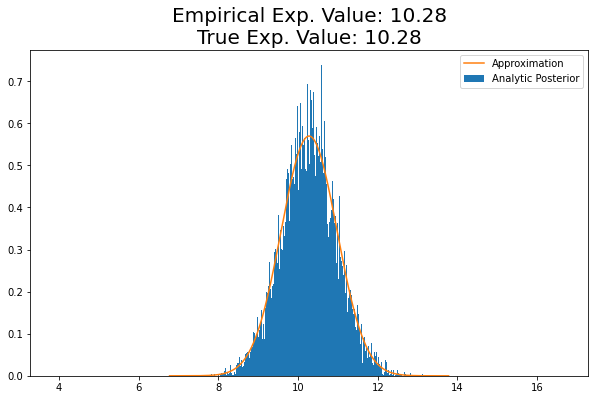

In [900]:
plt.figure(figsize=(10,6))
plt.hist(retained_samples, bins=500, density=True)
plt.xlim(mu_post-10*std_post, mu_post + 10*std_post)
x_post=np.linspace(mu_post-5*std_post, mu_post + 5*std_post, 1000000)
plt.plot(x_post, normal_pdf(x_post, mu_post, std_post), label='posterior')
plt.title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(retained_samples), 2),round(mu_post, 2) ), fontsize=20)
plt.legend(["Approximation","Analytic Posterior"])
plt.show()


In [889]:
proposal_widths=[1,2,3,4,5,6,7]
converg_time=[]
for std in proposal_widths:
    
    points,breaking_itr=mcmc_sampling(100000,5000,std,sample,800)
    converg_time.append(breaking_itr)
    


C:\Users\Jijo98\AppData\Local\Temp/ipykernel_1512/4116509783.py:46: RuntimeWarning: invalid value encountered in double_scalars
  r= min(1,(post_cur/post_prev))
C:\Users\Jijo98\AppData\Local\Temp/ipykernel_1512/4116509783.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  r= min(1,(post_cur/post_prev))


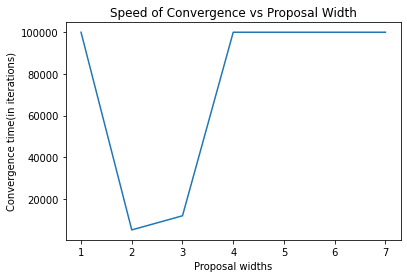

In [890]:
plt.plot(proposal_widths,converg_time)
plt.ylabel("Convergence time(in iterations)")
plt.xlabel("Proposal widths")
plt.title("Speed of Convergence vs Proposal Width")
plt.show()

## Proposal width's impact on Speed of Convergence and whatever follows

* The graph above features a distinctive phenomenon  where the speed of convergence initially plummeted as we move from 1 to 2, increased very gently from 2-3 and showed a rapid growth from [3-4]. 

* "2" is the best observable proposal width in the graph, however if a range is to be prescribed, [2-3] is a comfortable range to do so.

* If we're only concerned with lowering the speed of convergence we'll limit our proposal width to the range of [2-3], but that doesn't guarantee a good approximation of the posterior, as we'll see in the following section how early stoppage or when proposal width=2 affects the approximation.

In [904]:
#Running the experiment again with proposal_width=2 
burn_in=1000
retained_samples,itr=mcmc_sampling(100000,5000,2,sample,800)

retained_samples=retained_samples[burn_in:]
print("Algorithm converges at %s"%(itr))


C:\Users\Jijo98\AppData\Local\Temp/ipykernel_1512/1043222552.py:46: RuntimeWarning: invalid value encountered in double_scalars
  r= min(1,(post_cur/post_prev))
C:\Users\Jijo98\AppData\Local\Temp/ipykernel_1512/1043222552.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  r= min(1,(post_cur/post_prev))


Algorithm converges at 5000


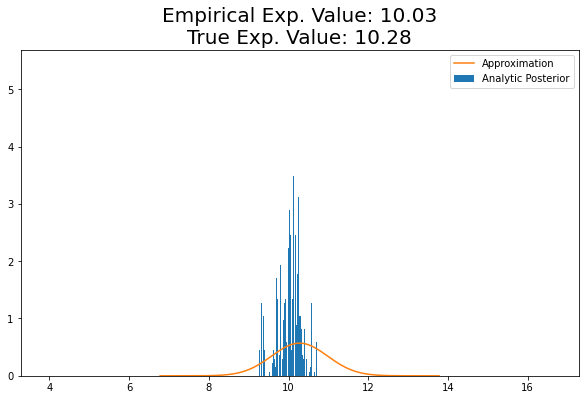

In [902]:
plt.figure(figsize=(10,6))
plt.hist(retained_samples, bins=500, density=True)
plt.xlim(mu_post-10*std_post, mu_post + 10*std_post)
x_post=np.linspace(mu_post-5*std_post, mu_post + 5*std_post, 1000000)
plt.plot(x_post, normal_pdf(x_post, mu_post, std_post), label='posterior')
plt.title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(retained_samples), 2),round(mu_post, 2) ), fontsize=20)
plt.legend(['Approximation','Analytic Posterior'])
plt.show()


## Effect of Early Stoppage 

Using "2" as a proposal width might speed up convergence to a great extent as witnessed earlier, but stopping earlier doesn't guarantee a good approximation of the posterior as visible in the graph, due to sheer scarcity of points being sampled. This is a necessary tradeoff between optimal fit and optimal convergence time. If the objective is optimal fit it's better to use "5" as the proposal width.

